### 📄 License

MIT (c) 2025 Sweety Seelam

----

# HeartRisk Assist — Medi-Hack 2025

**Tracks:** Diagnostics + Healthcare Ops (Fairness) + Mental Health (Privacy/Trust)  
**Team:** Solo - Sweety Seelam  
**Hackathon:** Medi-Hacks 2025 (Aug 18–23)

---

This notebook walks through the full pipeline:
1. Dataset overview  
2. Business challenge & goal  
3. Preprocessing & model training  
4. Calibration  
5. Model evaluation (ROC, PR, calibration)  
6. Fairness slices (age, sex, chest pain)  
7. SHAP explanations  
8. Export artifacts for the Streamlit app  
9. Business value, interpretation & recommendations

In [1]:
# Imports
import json, warnings, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, roc_curve, precision_recall_curve

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# optional shap (if installed)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

C:\Users\sweet\Desktop\DataScience\venvs\medihack\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ---------- Paths & seed ----------
# ---- constants (run first in the notebook) ----
ROOT = Path(r"C:\Users\sweet\Desktop\DataScience\Github projects\Case Study-Blog-Articles-Competitions\Online Competitions\DevPost\Medi-Hack-Devpost-Hackathon")
DATA = ROOT / "data" / "heart.csv"
ART  = ROOT / "artifacts"
ART.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

print("READ:", DATA.resolve())
print("WRITE:", ART.resolve())
assert DATA.exists(), f"Missing file: {DATA}"

READ: C:\Users\sweet\Desktop\DataScience\Github projects\Case Study-Blog-Articles-Competitions\Online Competitions\DevPost\Medi-Hack-Devpost-Hackathon\data\heart.csv
WRITE: C:\Users\sweet\Desktop\DataScience\Github projects\Case Study-Blog-Articles-Competitions\Online Competitions\DevPost\Medi-Hack-Devpost-Hackathon\artifacts


In [4]:
# Dataset Load & Preview
df = pd.read_csv(DATA)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
# ---------- Load & de-duplicate ----------
df = df.drop_duplicates(subset=df.columns.drop('target')).reset_index(drop=True)
print("Rows after dropping duplicate feature rows:", len(df))

Rows after dropping duplicate feature rows: 302


In [6]:
y = df["target"].astype(int)
X = df.drop(columns=["target"])

In [7]:
# Split: train/test, then fit/val for calibration
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

X_fit, X_val, y_fit, y_val = train_test_split(
    X_tr, y_tr,
    test_size=0.20,
    stratify=y_tr,
    random_state=RANDOM_STATE
)

In [8]:
# ---------- Preprocessor ----------
num_features = ["age","trestbps","chol","thalach","oldpeak"]
cat_features = [c for c in X.columns if c not in num_features]

In [9]:
# ---------- Preprocessor ----------
pre = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [10]:
# ---------- Model A: Logistic Regression (CV over C) ----------
pipe_lr = Pipeline([("pre", pre),
                    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs_lr = GridSearchCV(pipe_lr, {"clf__C":[0.1,1.0,3.0]}, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
gs_lr.fit(X_fit, y_fit)
print(f"LR  cv_auc: {gs_lr.best_score_:.4f} with {gs_lr.best_params_}")

LR  cv_auc: 0.9402 with {'clf__C': 0.1}


In [11]:
# ---------- Model B: Random Forest (constrained; CV over depth/leaves/trees) ----------
pipe_rf = Pipeline([("pre", pre),
                    ("clf", RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))])
grid_rf = {"clf__n_estimators":[200,400], "clf__max_depth":[3,5,7], "clf__min_samples_leaf":[5,10]}
gs_rf = GridSearchCV(pipe_rf, grid_rf, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
gs_rf.fit(X_fit, y_fit)
print(f"RF  cv_auc: {gs_rf.best_score_:.4f} with {gs_rf.best_params_}")

RF  cv_auc: 0.9448 with {'clf__max_depth': 7, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}


In [12]:
# ---------- Choose best by CV ----------
candidates = {"LR": gs_lr, "RF": gs_rf}
best_name = max(candidates.keys(), key=lambda k: candidates[k].best_score_)
best_gs   = candidates[best_name]
best_pipe = best_gs.best_estimator_
print("Selected by CV:", best_name)

Selected by CV: RF


In [13]:
# ---------- Calibrate on validation fold (prefit), then evaluate on test ----------
cal = CalibratedClassifierCV(best_pipe, method="isotonic", cv="prefit")
cal.fit(X_val, y_val)

probs = cal.predict_proba(X_te)[:,1]
auc   = roc_auc_score(y_te, probs)
aupr  = average_precision_score(y_te, probs)
brier = brier_score_loss(y_te, probs)
print(f"TEST ({best_name})  AUC: {auc:.4f}  AUPRC: {aupr:.4f}  Brier: {brier:.4f}")

TEST (RF)  AUC: 0.8782  AUPRC: 0.8857  Brier: 0.1438


In [14]:
# ---------- Bootstrap 95% CI for AUC ----------
rng = np.random.default_rng(123)
idx = y_te.index.to_numpy()
aucs = []
for _ in range(1000):
    bs = rng.choice(idx, size=len(idx), replace=True)
    aucs.append(roc_auc_score(y_te.loc[bs], pd.Series(probs, index=y_te.index).loc[bs]))
auc_ci = (np.percentile(aucs, 2.5), np.percentile(aucs, 97.5))
print(f"AUC 95% CI: [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}]")

AUC 95% CI: [0.789, 0.949]


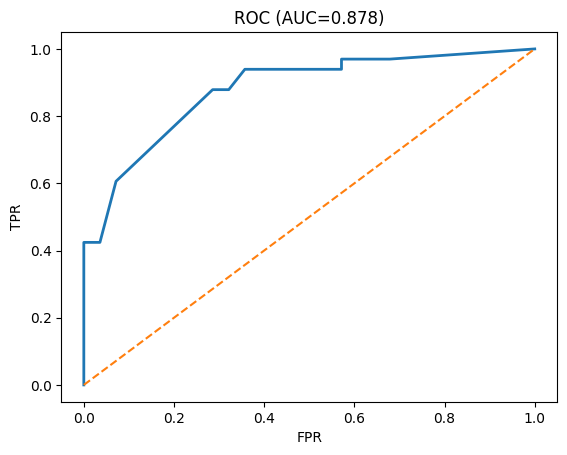

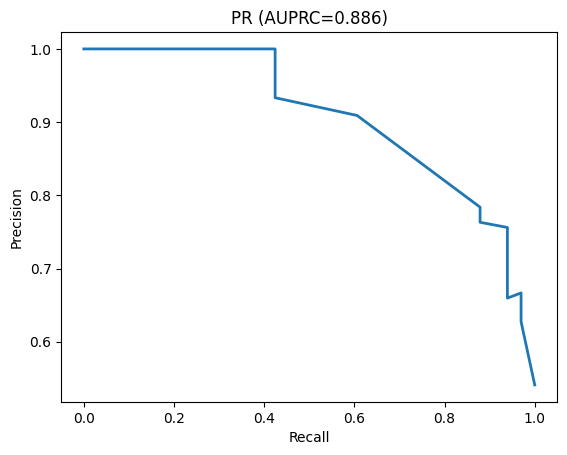

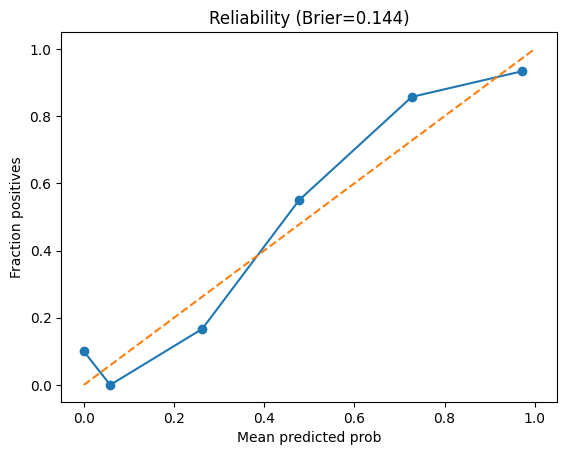

In [15]:
# ---------- Plots (use explicit figure handles; no blank PNGs) ----------
def save_curves(y_true, p, outdir, aucv, auprv, brierv):
    fpr, tpr, _ = roc_curve(y_true, p)
    fig, ax = plt.subplots(); ax.plot(fpr, tpr, lw=2); ax.plot([0,1],[0,1],'--')
    ax.set_title(f"ROC (AUC={aucv:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    plt.show()
    fig.savefig(ART/"roc.png", dpi=200, bbox_inches="tight"); plt.close(fig)

    prec, rec, _ = precision_recall_curve(y_true, p)
    fig, ax = plt.subplots(); ax.plot(rec, prec, lw=2)
    ax.set_title(f"PR (AUPRC={auprv:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    plt.show()
    fig.savefig(ART/"pr.png", dpi=200, bbox_inches="tight"); plt.close(fig)

    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy="quantile")
    fig, ax = plt.subplots(); ax.plot(mean_pred, frac_pos, "o-"); ax.plot([0,1],[0,1],"--")
    ax.set_title(f"Reliability (Brier={brierv:.3f})"); ax.set_xlabel("Mean predicted prob"); ax.set_ylabel("Fraction positives")
    plt.show()
    fig.savefig(ART/"reliability.png", dpi=200, bbox_inches="tight"); plt.close(fig)

save_curves(y_te, probs, ART, auc, aupr, brier)

In [16]:
# ---------- Fairness slices (aligned indices) ----------
probs_s = pd.Series(probs, index=y_te.index, copy=False)
slices = pd.DataFrame(index=y_te.index)
slices["sex"] = X.loc[y_te.index, "sex"].astype(int)
slices["age_bucket"] = pd.cut(X.loc[y_te.index, "age"], [0,45,60,120], labels=["lt45","45to60","gt60"])
slices["cp"] = X.loc[y_te.index, "cp"].astype(int)

def auc_by(col):
    out = {}
    for k, idx_g in slices.groupby(col, observed=True).groups.items():
        idx = list(idx_g)
        yt = y_te.loc[idx]
        if len(idx) >= 15 and yt.nunique() == 2:
            out[str(k)] = float(roc_auc_score(yt, probs_s.loc[idx]))
    return out

slice_report = {
    "auc_by_sex": auc_by("sex"),
    "auc_by_age_bucket": auc_by("age_bucket"),
    "auc_by_cp": auc_by("cp"),
}
print(json.dumps(f"slice_report: {slice_report}, indent=2"))

"slice_report: {'auc_by_sex': {'0': 0.8461538461538461, '1': 0.8706521739130435}, 'auc_by_age_bucket': {'45to60': 0.8777777777777778, 'gt60': 0.7523809523809524}, 'auc_by_cp': {'0': 0.8486842105263157}}, indent=2"


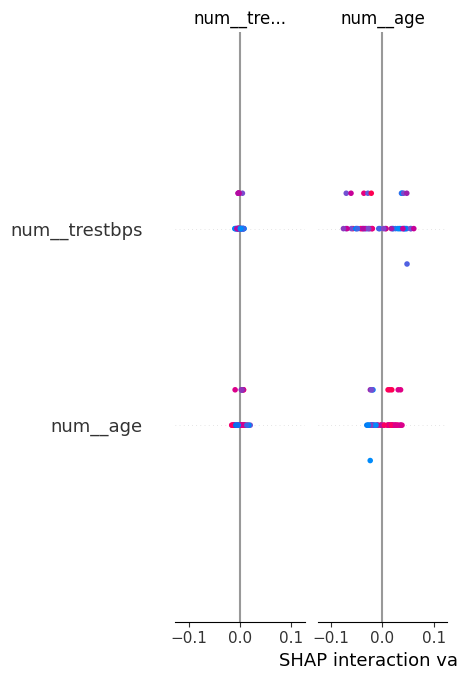

Saved SHAP: C:\Users\sweet\Desktop\DataScience\Github projects\Case Study-Blog-Articles-Competitions\Online Competitions\DevPost\Medi-Hack-Devpost-Hackathon\artifacts\shap_summary.png
metrics.json updated: {'available': True, 'method': 'tree'}


In [17]:
# --- SHAP (robust for RF or LR) : display + save to artifacts/shap_summary.png
import json, warnings, traceback
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore", category=UserWarning)

def _unwrap_calibrated(model, fallback_pre):
    """Return (preprocessor, final_clf) from a CalibratedClassifierCV or a plain estimator."""
    est = model
    if isinstance(model, CalibratedClassifierCV):
        if getattr(model, "calibrated_classifiers_", None):
            cc = model.calibrated_classifiers_[0]
            est = getattr(cc, "estimator", getattr(cc, "base_estimator", model))
        else:
            est = getattr(model, "estimator", getattr(model, "base_estimator", model))
    pre_used, clf_used = fallback_pre, est
    if isinstance(est, Pipeline) and hasattr(est, "named_steps"):
        pre_used = est.named_steps.get("pre", fallback_pre)
        clf_used = est.named_steps.get("clf", est)
    if pre_used is None:
        raise RuntimeError("Preprocessor not found")
    return pre_used, clf_used

try:
    import shap

    pre_used, clf_used = _unwrap_calibrated(cal, pre)

    # transform data as the model sees it (dense arrays for plotting)
    Xbg = pre_used.transform(X_fit.sample(min(len(X_fit), 200), random_state=RANDOM_STATE))
    X50 = pre_used.transform(X_te.head(50))
    if sp.issparse(Xbg): Xbg = Xbg.toarray()
    if sp.issparse(X50): X50 = X50.toarray()
    feat_names = pre_used.get_feature_names_out(X.columns)

    # choose explainer and get SHAP values
    if hasattr(clf_used, "estimators_"):            # RandomForest / tree
        expl = shap.TreeExplainer(clf_used)         # default model_output='raw' (OK)
        sv = expl.shap_values(X50)                  # list for binary: [neg, pos]
        sv_to_plot = sv[1] if isinstance(sv, list) else sv
        shap.summary_plot(sv_to_plot, X50, feature_names=feat_names, show=False)
        shap_status = {"available": True, "method": "tree"}

    elif hasattr(clf_used, "coef_"):                # Logistic Regression / linear
        expl = shap.LinearExplainer(clf_used, Xbg)
        # Works across SHAP versions: may return array or Explanation
        try:
            sv = expl(X50)                          # Explanation in newer versions
            try:
                # If it's an Explanation, summary_plot can take it directly
                shap.summary_plot(sv, X50, feature_names=feat_names, show=False)
            except Exception:
                shap.summary_plot(sv.values, X50, feature_names=feat_names, show=False)
        except Exception:
            sv = expl.shap_values(X50)              # older versions return array
            shap.summary_plot(sv, X50, feature_names=feat_names, show=False)
        shap_status = {"available": True, "method": "linear"}

    else:
        raise RuntimeError("Unsupported model type for fast SHAP.")

    # save + show
    fig = plt.gcf()
    out_path = ART/"shap_summary.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print("Saved SHAP:", out_path.resolve())

    # mark availability so Streamlit shows it
    try:
        m = json.load(open(ART/"metrics.json"))
    except FileNotFoundError:
        m = {}
    m["shap"] = shap_status
    json.dump(m, open(ART/"metrics.json","w"), indent=2)
    print("metrics.json updated:", shap_status)

except Exception as e:
    print("SHAP skipped / failed:", e)
    traceback.print_exc()

In [18]:
# ---------- Save artifacts ----------
joblib.dump({"model": cal, "features": list(X.columns), "preprocessor": pre}, ART/"model.pkl")

with open(ART/"metrics.json","w") as f:
    json.dump({
        "auc": float(auc), "aupr": float(aupr), "brier": float(brier),
        "auc_ci": [float(auc_ci[0]), float(auc_ci[1])],
        "cv_choice": best_name, "cv_best_score": float(best_gs.best_score_),
        "shap": shap_status,
        **slice_report
    }, f, indent=2)

print("Saved artifacts: model.pkl, metrics.json, roc.png, pr.png, reliability.png",
      "(+ shap_summary.png if available)")

Saved artifacts: model.pkl, metrics.json, roc.png, pr.png, reliability.png (+ shap_summary.png if available)


In [19]:
p = ART/"shap_summary.png"
print(p.exists(), p.stat().st_size if p.exists() else 0, "bytes")

True 42863 bytes


In [20]:
print("Artifacts dir:", ART.resolve())
for p in (ART / "roc.png", ART / "pr.png", ART / "reliability.png", ART / "shap_summary.png", ART / "metrics.json", ART / "model.pkl"):
    print(p.name, "exists:", p.exists(), "size:", p.stat().st_size if p.exists() else 0, "bytes")

Artifacts dir: C:\Users\sweet\Desktop\DataScience\Github projects\Case Study-Blog-Articles-Competitions\Online Competitions\DevPost\Medi-Hack-Devpost-Hackathon\artifacts
roc.png exists: True size: 51544 bytes
pr.png exists: True size: 42637 bytes
reliability.png exists: True size: 70582 bytes
shap_summary.png exists: True size: 42863 bytes
metrics.json exists: True size: 528 bytes
model.pkl exists: True size: 522136 bytes
